# Project 2 - Ames Housing Data and Kaggle Challenge


## Problem Statement
The intend of this project is to create and select the best regression model for predicting housing sales price.

### General approach

- [Load train data](#Load-Data)
- [Data Imputation ](#Data-Imputation)
- [Speparating variable types (nominal, ordinal, discrete, continuous)](#Separating-variable-types)
- [Within each types, filter out columns that are not relevant accordingly based on point 5 and 6](#Dropping-features-with-low-variance)
- [For categorial variables, filter out columns that have high frequency of the same category, based on a threshold value (can be tweaked)](#Dropping-features-with-low-variance)
- [EDA scatter plots and histograms](#Feature-engineering)
- [Dropping outliers](#Dropping-outliers)
- [Label encoding ordinal categorial variables](#Label-Encoding-for-Ordinal-Categories)
- [One hot encoding nominal categorial variables](#One-hot-encoding-on-nominal-category)
- [For continuous variables, use correlation with sales prices to narrow down features](#Filtering-continuous-data-using-sales-price-correlation)
- [Adding polynominal features](#Adding-polynomial-features)
- [Train-test split, standard scaling and cross validation](#Train-test-split)
- [Model scoring and selection](#Model-scoring)
- [Cleaning test data](#Cleaning-test-data)
- [Fitting test data with best selected model](#Fitting-test-data)
- [Visualize top lasso/ridge coefficients](#Top-coefficients)
- [Output predicted sales price to csv for kaggle submission](#Output-results-to-csv)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew 
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

### Load Data

In [2]:
df = pd.read_csv('../data/train.csv')

In [3]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
df.drop(['Id', 'PID'], axis = 1, inplace = True) # Drop ID columns

### Data Imputation

Find out columns with missing values and the percentage of missing data

In [5]:
def get_missing_cols(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing = pd.concat([total, percent], axis=1, keys=['missing_count', 'missing_percentage'])
    missing_df = missing[missing['missing_percentage'] > 0]
    return missing_df

In [6]:
missing_cols = get_missing_cols(df)
missing_cols

,missing_count,missing_percentage
Pool QC,2042,99.561190
Misc Feature,1986,96.830814
Alley,1911,93.174061
Fence,1651,80.497318
Fireplace Qu,1000,48.756704
Lot Frontage,330,16.089712
Garage Qual,114,5.558264
Garage Cond,114,5.558264
Garage Yr Blt,114,5.558264
Garage Finish,114,5.558264


Null cols with less than 0.1% of data can be filtered and dropped

In [7]:
rowid_to_remove = set(df[df[col].isnull()].index[0] 
                       for col in missing_cols[missing_cols['missing_percentage'] < 1].index)
rowid_to_remove

{616, 1327, 1712}

In [8]:
df.shape

(2051, 79)

In [9]:
df.drop(rowid_to_remove, inplace=True) # drop null rows that are less than 1% missing percentage
df.shape

(2048, 79)

Filling missing data:
- Missing values most likely means the house does not come with basement or garage hence it is safe to fill them with 0 or 'None'.

- Making assumption that houses in same neighbourhood likely have similar Lot frontage

In [10]:
def handle_missing_data(df, missing_cols):
    
    missing_str_cols = df[missing_cols.index].select_dtypes(include='object').columns # Missing cols with string type
    missing_num_cols = df[missing_cols.index].select_dtypes(exclude='object').columns # Missing cols with numeric type
    
    # Using neighbourhood median to determine Lot frontage
    df.groupby("Neighborhood")["Lot Frontage"].transform(lambda x: x.fillna(x.median()))
    
    # Fill rest of string missing value with None
    for col in missing_str_cols: 
        df[col] = df[col].fillna("None")
        
    # Fill rest of numeric missing value with 0
    for col in missing_num_cols: 
        df[col] = df[col].fillna(0)
    
    return df

In [11]:
handle_missing_data(df, missing_cols);

In [12]:
# Verify that there is no more missing values
df.isnull().sum().sum()

0

### Separating variable types

In [13]:
# List of cols with nominal variables
nominal_cols = [
    'MS SubClass',
    'MS Zoning',
    'Street',
    'Alley',
    'Land Contour',
    'Lot Config',
    'Neighborhood',
    'Condition 1',
    'Condition 2',
    'Bldg Type',
    'House Style',
    'Roof Style',
    'Roof Matl',
    'Exterior 1st',
    'Exterior 2nd',
    'Mas Vnr Type',
    'Foundation',
    'Heating',
    'Central Air',
    'Garage Type',
    'Misc Feature',
    'Sale Type'
]

In [14]:
# List of cols with ordinal variables
ordinal_cols = [
    'Lot Shape',
    'Utilities',
    'Land Slope',
    'Overall Qual',
    'Overall Cond',
    'Exter Qual',
    'Exter Cond',
    'Bsmt Qual',
    'Bsmt Cond',
    'Bsmt Exposure',
    'BsmtFin Type 1',
    'BsmtFin Type 2',
    'Heating QC',
    'Electrical',
    'Kitchen Qual',
    'Functional',
    'Fireplace Qu',
    'Garage Finish',
    'Garage Qual',
    'Garage Cond',
    'Paved Drive',
    'Pool QC',
    'Fence'
]


In [15]:
# List of cols with discrete variables
discrete_cols = [
    'Year Built',
    'Year Remod/Add',
    'Bsmt Full Bath',
    'Bsmt Half Bath',
    'Full Bath',
    'Half Bath',
    'Bedroom AbvGr',
    'Kitchen AbvGr',
    'TotRms AbvGrd',
    'Fireplaces',
    'Garage Yr Blt',
    'Garage Cars',
    'Mo Sold',
    'Yr Sold'
]

In [16]:
# List of cols with continuous variables
continuous_cols = [
    'Lot Frontage',
    'Lot Area',
    'Mas Vnr Area',
    'BsmtFin SF 1',
    'BsmtFin SF 2',
    'Bsmt Unf SF',
    'Total Bsmt SF',
    '1st Flr SF',
    '2nd Flr SF',
    'Low Qual Fin SF',
    'Gr Liv Area',
    'Garage Area',
    'Wood Deck SF',
    'Open Porch SF',
    'Enclosed Porch',
    '3Ssn Porch',
    'Screen Porch',
    'Pool Area',
    'Misc Val',
    'SalePrice'
]

### Dropping features with low variance

In [17]:
def filter_categorical_cols(df, lower_bound = 0.1, upper_bound = 0.9):
    """
    Filters out columns with low variance. 
    """
    filtered_cols = []
    max_row = df.shape[0]
    for col in df.columns:
        max_value_count = df[col].value_counts().max()
        if (max_value_count/max_row) > lower_bound and (max_value_count/max_row) < upper_bound:
            filtered_cols.append(col)
    return filtered_cols

In [18]:
def filter_discrete_cols(df, threshold = 14, lower_bound = 0.1, upper_bound = 0.9):
    """
    Filters out columns with low variance
    """
    filtered_cols = []
    max_row = df.shape[0]
    
    for col in df.columns:
        if df[col].value_counts().count() > threshold:
            filtered_cols.append(col)
        else:
            max_value_count = df[col].value_counts().max()
            len_value_count = df[col].value_counts().count()
            if (max_value_count/max_row) > lower_bound and (max_value_count/max_row) < upper_bound:
                filtered_cols.append(col)       
    return filtered_cols

In [19]:
def filter_continuous_cols(df, skew_threshold = 4):
    """
    Filter out continuous variable columns with low variance and high skewness with the help of scipy.stats
    Parameters: 
        - df = the pandas DataFrame to read in for filtering
        - skew_threshold = high skew_threshold means getting cols even with very skewed data
    Returns:
        Filtered continuous columns
    """
    return [col for col in df.columns if -skew_threshold <= skew(df[col]) <= skew_threshold]


In [20]:
def subplot_histograms(df):
    list_of_columns = df.columns
    nrows = int(np.ceil(len(list_of_columns)/4))
    fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(20,20))
    ax = ax.ravel()
    for i, column in enumerate(list_of_columns):
        ax[i].hist(df[column], bins=15)
        ax[i].set_title(list_of_columns[i])
        ax[i].axvline(np.mean(df[column]), color='black', linestyle='--', lw=3);

Dropping categorical cols where 90% or more of the values are the same (low variance)

In [21]:
# Filter Categorical variable columns 
filtered_ordinal_cols = filter_categorical_cols(df[ordinal_cols])
filtered_nominal_cols = filter_categorical_cols(df[nominal_cols])

Quick view of how the continuous variable columns are skewed

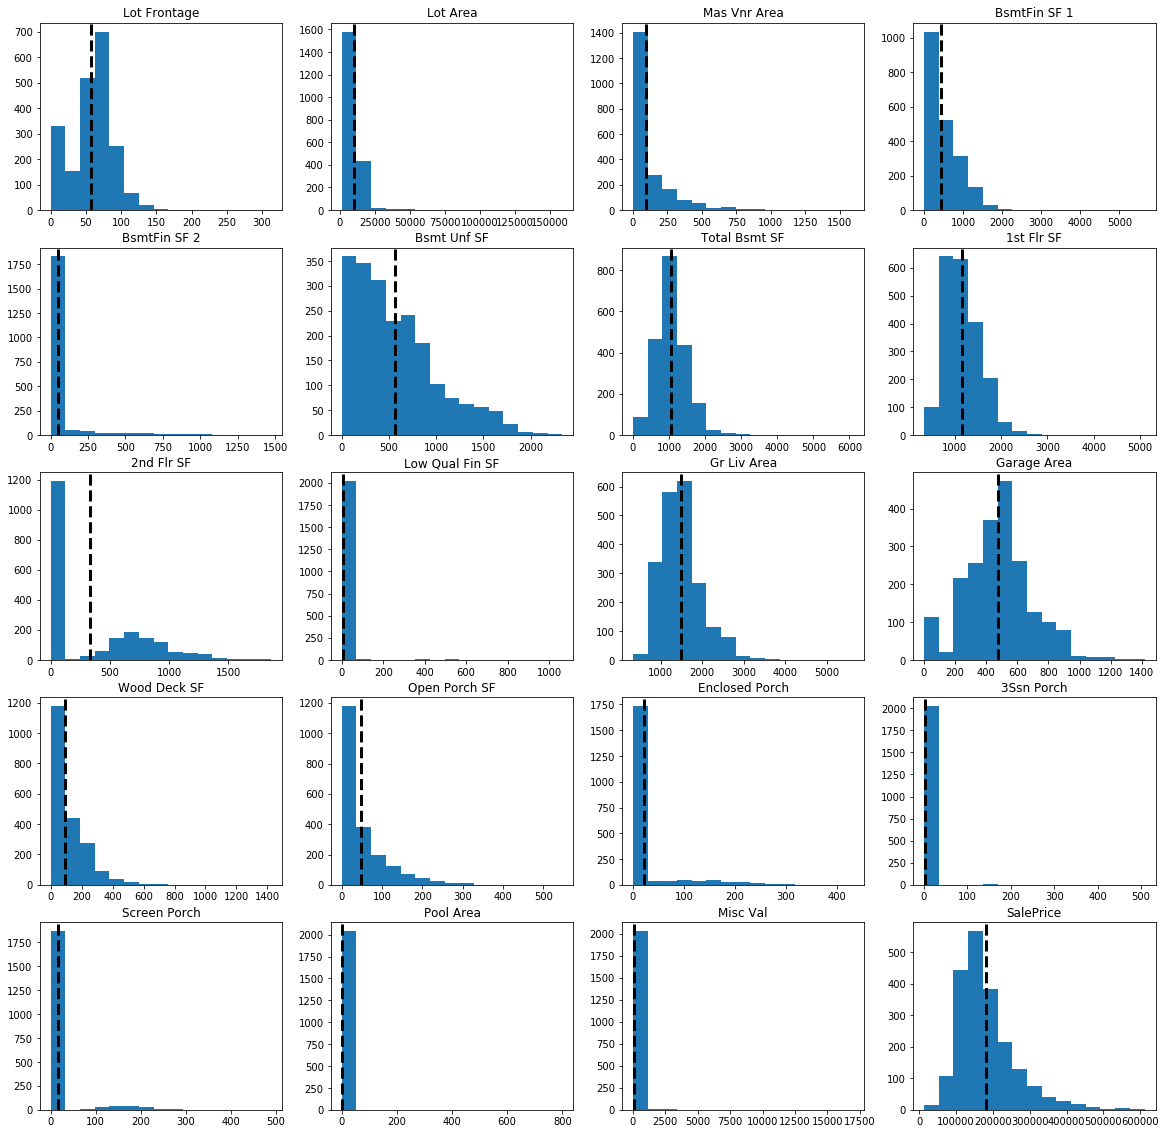

In [22]:
subplot_histograms(df[continuous_cols])

In [23]:
# Filter Continuous variable columns
filtered_continuous_cols = filter_continuous_cols(df[continuous_cols])
filtered_continuous_cols # Compare output with subplot above

['Lot Frontage',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Gr Liv Area',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 'Screen Porch',
 'SalePrice']

Quick view of how discrete variable columns are skewed

In [24]:
df[discrete_cols].head()

,Year Built,Year Remod/Add,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Mo Sold,Yr Sold
0,1976,2005,0.0,0.0,2,1,3,1,6,0,1976.0,2.0,3,2010
1,1996,1997,1.0,0.0,2,1,4,1,8,1,1997.0,2.0,4,2009
2,1953,2007,1.0,0.0,1,0,3,1,5,0,1953.0,1.0,1,2010
3,2006,2007,0.0,0.0,2,1,3,1,7,0,2007.0,2.0,4,2010
4,1900,1993,0.0,0.0,2,0,3,1,6,0,1957.0,2.0,3,2010


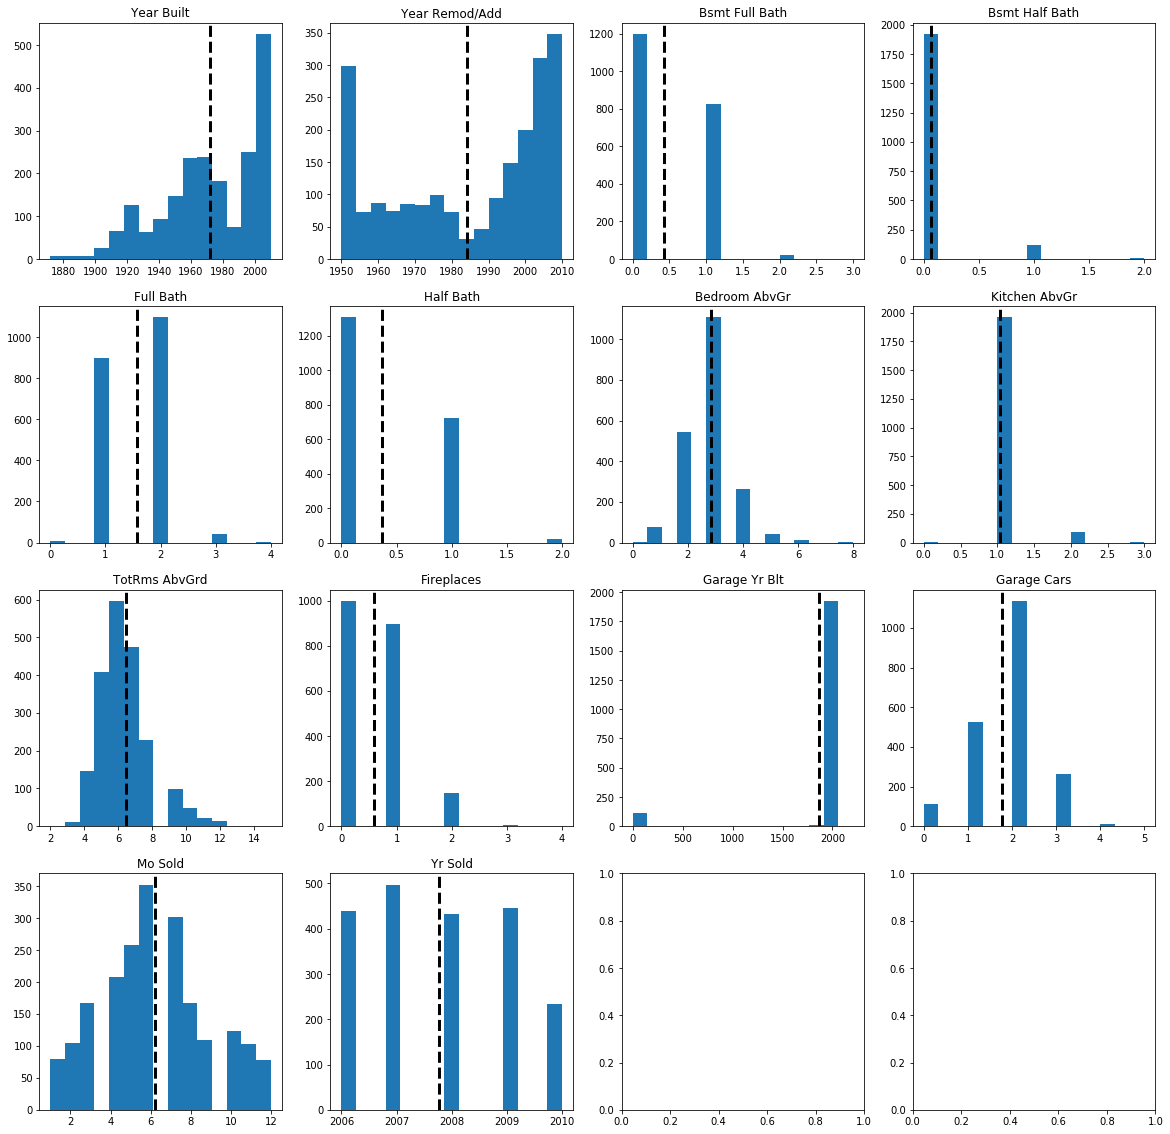

In [25]:
subplot_histograms(df[discrete_cols])

In [26]:
# Filter discrete variable columns
filtered_discrete_cols = filter_discrete_cols(df[discrete_cols])
filtered_discrete_cols # Compare output with subplot above

['Year Built',
 'Year Remod/Add',
 'Bsmt Full Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Mo Sold',
 'Yr Sold']

In [27]:
filtered_discrete_cols.remove('Garage Yr Blt') # Low variance data

First Cut Remaining Features

In [28]:
features = filtered_discrete_cols + filtered_continuous_cols + filtered_nominal_cols + filtered_ordinal_cols

In [29]:
len(features)

56

### Feature engineering

In [30]:
def subplot_scatters(df):
    list_of_columns = df.columns
    nrows = int(np.ceil(len(list_of_columns)/3))
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(20,20))
    ax = ax.ravel()
    for i, column in enumerate(list_of_columns):
        ax[i].scatter(df[column], df['SalePrice'])
        ax[i].set_title(list_of_columns[i]);

Scatter Plot of different continuous variable and Sale Price to find outliers

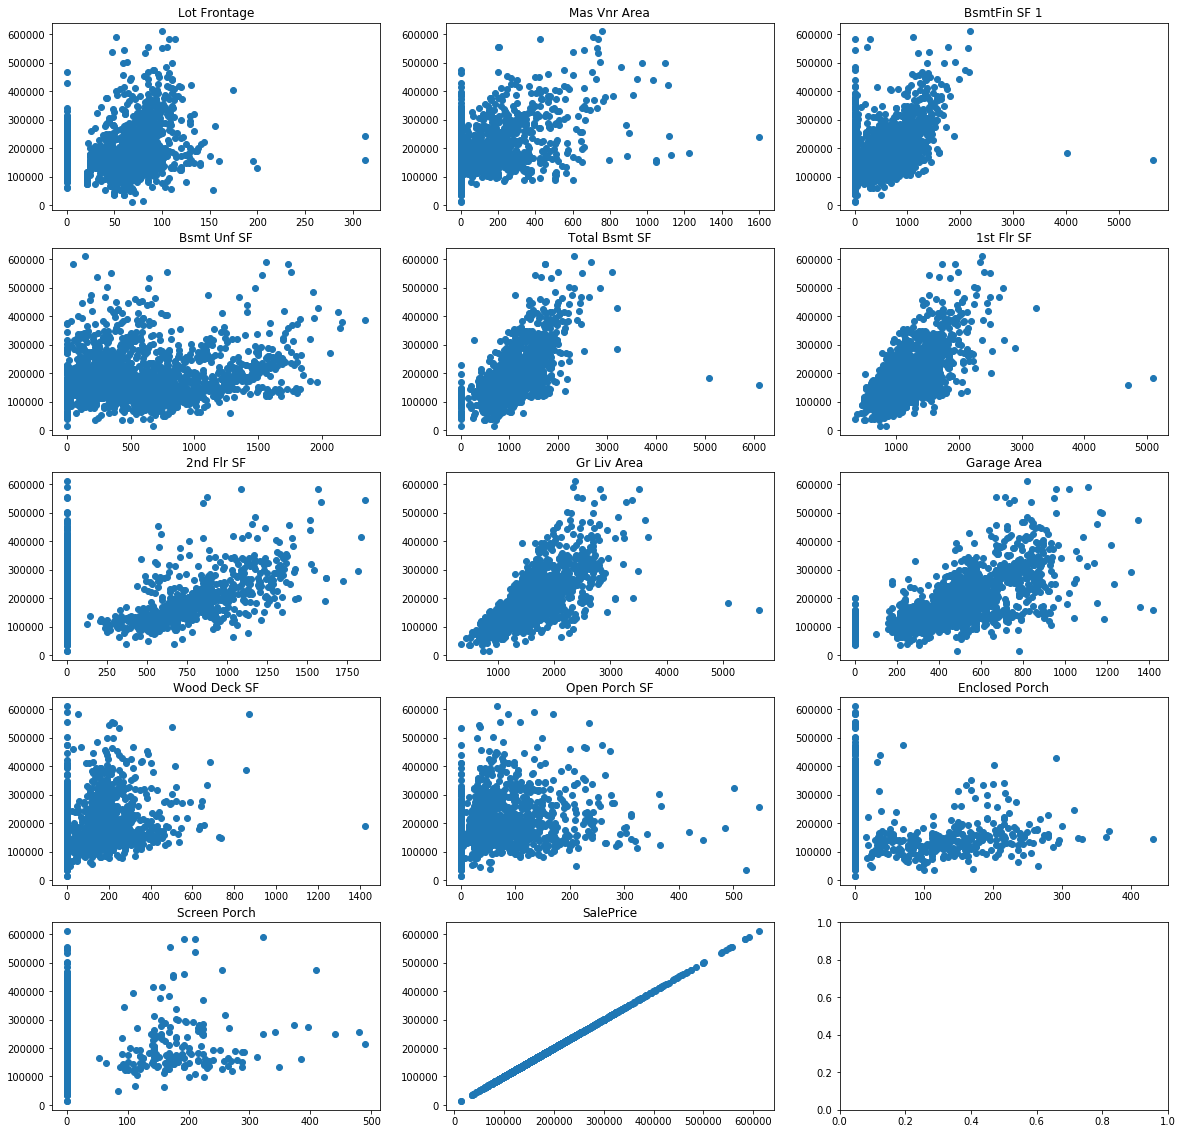

In [31]:
subplot_scatters(df[filtered_continuous_cols])

### Dropping outliers

In [32]:
outlier_rows_index = set(list(df[df['Gr Liv Area'] > 4000].index) +
                         list(df[df['BsmtFin SF 1'] > 3000].index) +
                         list(df[df['Total Bsmt SF'] > 4000].index) +
                         list(df[df['Lot Frontage'] > 175].index) +
                         list(df[df['1st Flr SF'] > 3500].index))

In [33]:
outlier_rows_index

{441, 960, 1335, 1875, 1885}

In [34]:
df.drop(outlier_rows_index, inplace=True) # drop outlier rows

In [35]:
df.shape

(2043, 79)

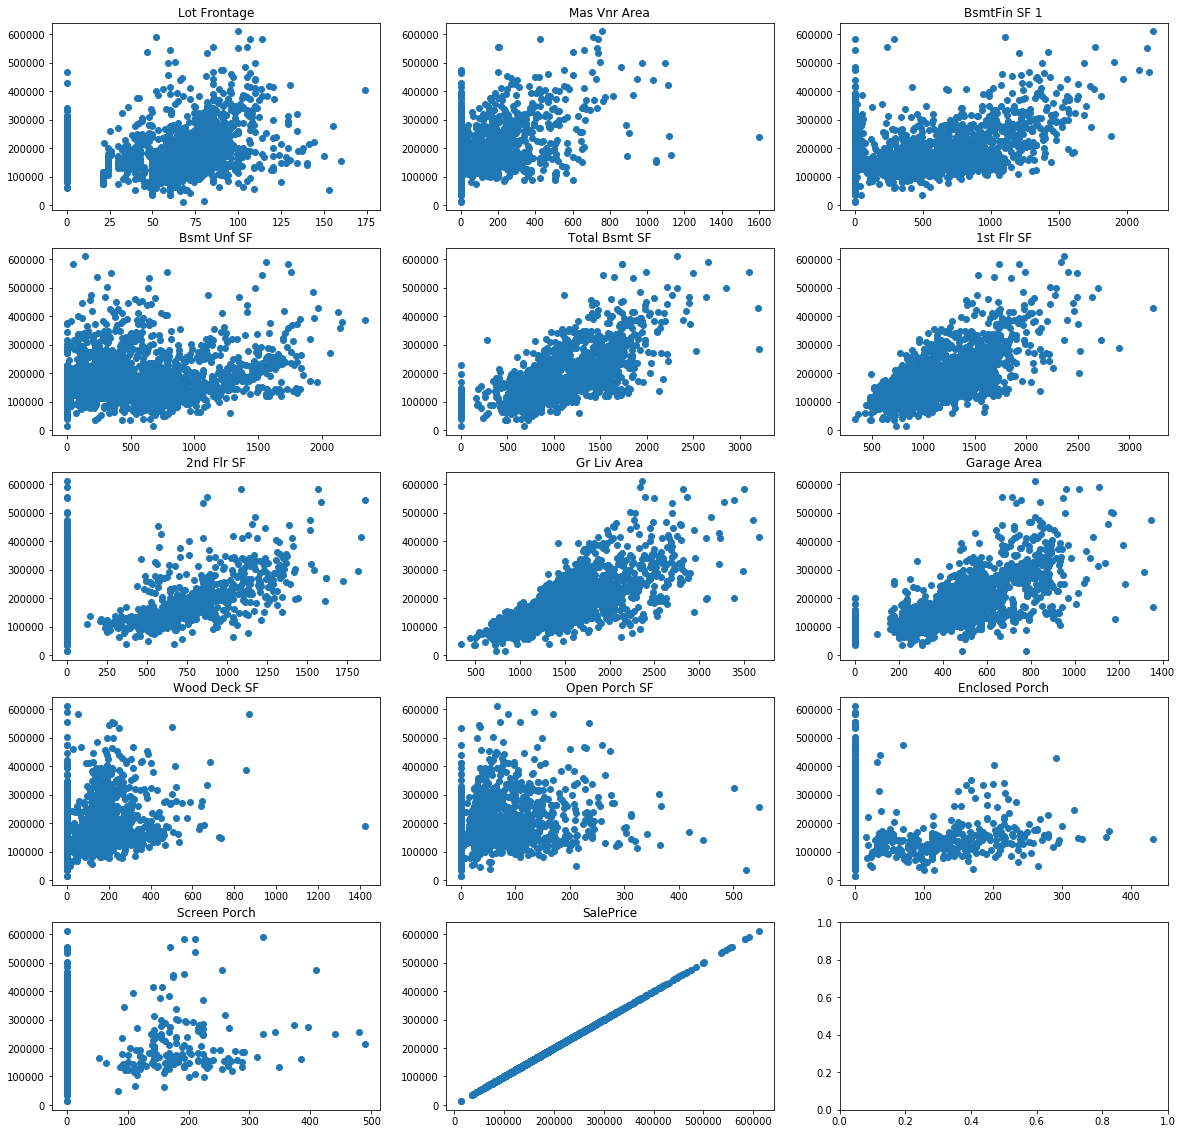

In [36]:
subplot_scatters(df[filtered_continuous_cols])

Dropping more outliers

In [37]:
outlier_rows_index = set(list(df[df['Wood Deck SF'] > 1200].index) +
                         list(df[df['Mas Vnr Area'] > 1400].index))

In [38]:
outlier_rows_index

{966, 1409}

In [39]:
df.drop(outlier_rows_index, inplace=True) # drop outlier rows

In [40]:
df.shape

(2041, 79)

### EDA on year built

In [41]:
year_step_size = 5 
labels = ["{0} - {1}".format(i, i + year_step_size - 1) for i in range(1870, 2015, year_step_size)]
df['year_built_bin'] = pd.cut(df['Year Built'], bins=range(1870, 2020, year_step_size), labels= labels)

labels = ["{0} - {1}".format(i, i + year_step_size - 1) for i in range(1945, 2010, year_step_size)]
df['year_remod_add_bin'] = pd.cut(df['Year Remod/Add'], bins=range(1945, 2015, year_step_size), labels= labels)

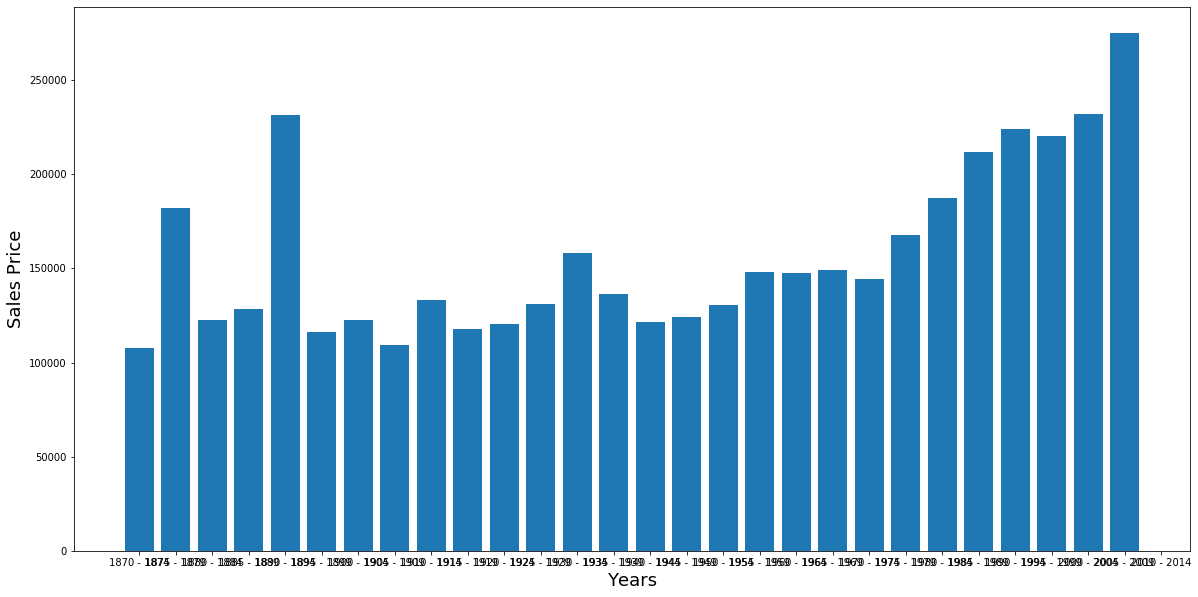

In [42]:
plt.figure(figsize=(20,10))
plt.bar(np.array(df.groupby('year_built_bin', as_index=False)['SalePrice'].mean()['year_built_bin'])
        ,df.groupby('year_built_bin', as_index=False)['SalePrice'].mean()['SalePrice'])
plt.ylabel('Sales Price', fontsize=18)
plt.xlabel('Years', fontsize=18);

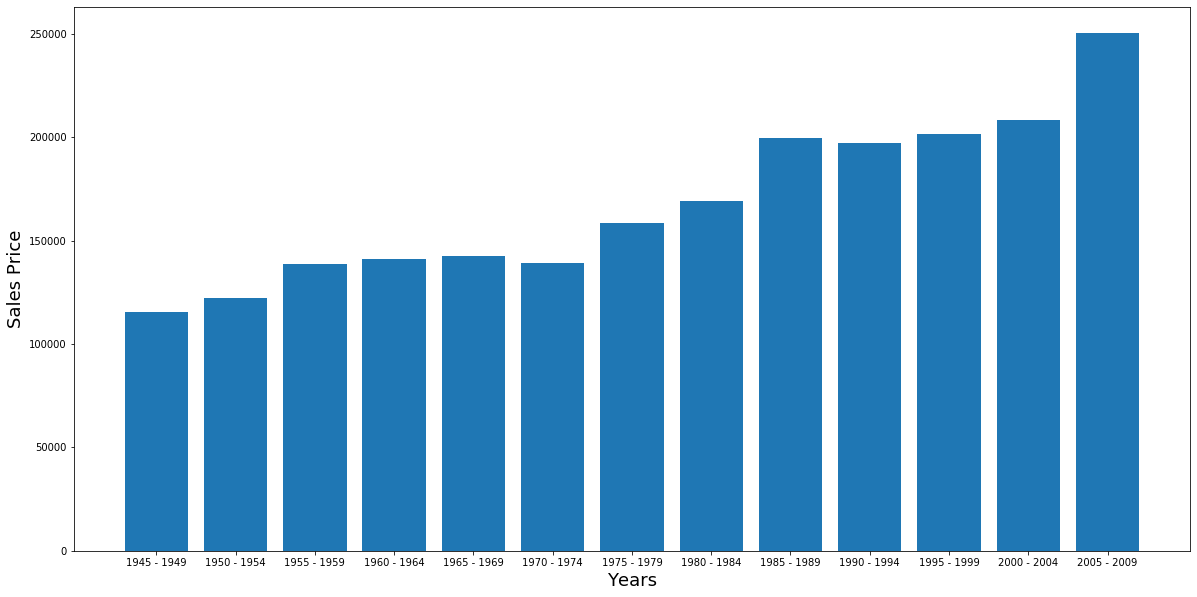

In [43]:
plt.figure(figsize=(20,10))
plt.bar(np.array(df.groupby('year_remod_add_bin', as_index=False)['SalePrice'].mean()['year_remod_add_bin'])
        ,df.groupby('year_remod_add_bin', as_index=False)['SalePrice'].mean()['SalePrice'])
plt.ylabel('Sales Price', fontsize=18)
plt.xlabel('Years', fontsize=18);

Tried binning years and fit in model but results does not show any improvement hence not included

In [44]:
# df['year_built_bin'] = df['year_built_bin'].map(lambda x: list(range(1870, 2015, 5)).index(int(str(x).split('-')[0])) + 1)

In [45]:
# df['year_remod_add_bin'] = df['year_remod_add_bin'].map(lambda x: list(range(1945, 2010, 5)).index(int(str(x).split('-')[0])) + 1)

In [46]:
# filtered_discrete_cols.remove('Year Built')
# filtered_discrete_cols.remove('Year Remod/Add')
# filtered_ordinal_cols.extend(['year_built_bin', 'year_remod_add_bin']) # Convert discrete data to ordinal categorical

### Adding new features by combining certain cols

Model not showing any improvements hence not included

In [47]:
# total_sq_ft = df['1st Flr SF'] + df['2nd Flr SF'] + df['Total Bsmt SF']
# df['total_sf'] = total_sq_ft
# filtered_continuous_cols.append('total_sf')
# filtered_continuous_cols.remove('1st Flr SF')
# filtered_continuous_cols.remove('2nd Flr SF')
# filtered_continuous_cols.remove('Total Bsmt SF')

### Label Encoding for Ordinal Categories

In [48]:
df[filtered_ordinal_cols].head()

,Lot Shape,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Kitchen Qual,Fireplace Qu,Garage Finish,Garage Qual,Fence
0,IR1,6,8,Gd,TA,TA,TA,No,GLQ,Unf,Ex,Gd,None,RFn,TA,None
1,IR1,7,5,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,Gd,TA,RFn,TA,None
2,Reg,5,7,TA,Gd,TA,TA,No,GLQ,Unf,TA,Gd,None,Unf,TA,None
3,Reg,5,5,TA,TA,Gd,TA,No,Unf,Unf,Gd,TA,None,Fin,TA,None
4,IR1,6,8,TA,TA,Fa,Gd,No,Unf,Unf,TA,TA,None,Unf,TA,None


In [49]:
df[filtered_ordinal_cols].columns

Index(['Lot Shape', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu',
       'Garage Finish', 'Garage Qual', 'Fence'],
      dtype='object')

In [50]:
ordinal_cat_ranking = {
    'Lot Shape': ['IR3', 'IR2','IR1','Reg'],
    'Exter Qual': ['Po','Fa','TA','Gd','Ex'], 
    'Exter Cond': ['Po','Fa','TA','Gd','Ex'], 
    'Bsmt Qual': ['None','Po','Fa','TA','Gd','Ex'], 
    'Bsmt Cond': ['None','Po','Fa','TA','Gd','Ex'], 
    'Bsmt Exposure': ['None','No','Mn','Av','Gd'], 
    'BsmtFin Type 1': ['None','Unf','LwQ','Rec','BLQ','ALQ','GLQ'], 
    'BsmtFin Type 2': ['None','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'Heating QC': ['Po','Fa','TA','Gd','Ex'],
    'Kitchen Qual': ['Po','Fa','TA','Gd','Ex'],
    'Fireplace Qu': ['None','Po','Fa','TA','Gd','Ex'],
    'Garage Finish': ['None','Unf','RFn','Fin'],
    'Garage Qual': ['None','Po','Fa','TA','Gd','Ex'],
    'Fence': ['None','MnWw','GdWo','MnPrv','GdPrv']             
}

In [51]:
# Label Encode
for col in ordinal_cat_ranking:
    df[col] = df[col].map(lambda x: ordinal_cat_ranking[col].index(x) + 1)

In [52]:
df[filtered_ordinal_cols].head()

,Lot Shape,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Kitchen Qual,Fireplace Qu,Garage Finish,Garage Qual,Fence
0,3,6,8,4,3,4,4,2,7,2,5,4,1,3,4,1
1,3,7,5,4,3,5,4,2,7,2,5,4,4,3,4,1
2,4,5,7,3,4,4,4,2,7,2,3,4,1,2,4,1
3,4,5,5,3,3,5,4,2,2,2,4,3,1,4,4,1
4,3,6,8,3,3,3,5,2,2,2,3,3,1,2,4,1


### Convert discrete cols to integers

In [53]:
df[filtered_discrete_cols] = df[filtered_discrete_cols].astype(int) # Convert all discrete values to integer

### One hot encoding on nominal category

1. Filter out nominal category that have low variance of mean price per category

In [54]:
df[filtered_nominal_cols].head()

,MS SubClass,MS Zoning,Land Contour,Lot Config,Neighborhood,Condition 1,Bldg Type,House Style,Roof Style,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Garage Type,Sale Type
0,60,RL,Lvl,CulDSac,Sawyer,RRAe,1Fam,2Story,Gable,HdBoard,Plywood,BrkFace,CBlock,Attchd,WD
1,60,RL,Lvl,CulDSac,SawyerW,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,PConc,Attchd,WD
2,20,RL,Lvl,Inside,NAmes,Norm,1Fam,1Story,Gable,VinylSd,VinylSd,None,CBlock,Detchd,WD
3,60,RL,Lvl,Inside,Timber,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,None,PConc,BuiltIn,WD
4,50,RL,Lvl,Inside,SawyerW,Norm,1Fam,1.5Fin,Gable,Wd Sdng,Plywood,None,PConc,Detchd,WD


In [55]:
df.groupby('MS Zoning').agg({'MS Zoning':'size', 'SalePrice':'mean'}).rename(columns={'MS Zoning': 'Count'})

,Count,SalePrice
MS Zoning,,
A (agr),2,47300.000000
C (all),19,78010.894737
FV,100,218414.500000
I (all),1,57625.000000
RH,14,148859.571429
RL,1591,191232.082338
RM,314,129209.363057


In [56]:
print('Std of MS Zoning', df.groupby('MS Zoning').agg({'MS Zoning':'size', 'SalePrice':'mean'})['SalePrice'].std())

Std of MS Zoning 66435.32018115005


Find columns with high variance

In [57]:
pd.DataFrame.from_dict({col: df.groupby(col).agg({col:'size', 'SalePrice':'mean'})['SalePrice'].std() 
              for col in filtered_nominal_cols}, orient='index', 
                       columns=['std']).sort_values(by='std', ascending=False)

,std
Neighborhood,67054.921453
MS Zoning,66435.320181
Exterior 1st,57529.541044
Sale Type,55903.517519
Mas Vnr Type,55717.017364
Garage Type,52985.584658
Land Contour,50460.374194
Condition 1,49824.093031
Foundation,42876.216319
House Style,41615.408802


In [58]:
df.groupby('Lot Config').agg({'Lot Config':'size', 'SalePrice':'mean'}).rename(columns={'Lot Config': 'Count'})

,Count,SalePrice
Lot Config,,
Corner,346,180667.913295
CulDSac,131,230744.358779
FR2,59,175037.559322
FR3,8,213550.000000
Inside,1497,177426.635939


2. Drop nominal cols with low variance of mean price per category


In [59]:
filtered_nominal_cols = [col for col in filtered_nominal_cols 
                         if col not in ['Lot Config', 'Roof Style', 'Exterior 2nd','MS SubClass']]

3. One hot encoding

In [60]:
filtered_nominal_dummies_cols = list(pd.get_dummies(df[filtered_nominal_cols].astype(str)).columns)

4. Join dataframe

In [61]:
df = df.join(pd.get_dummies(df[filtered_nominal_cols].astype(str))) # join original df with dummies df

### Filtering continuous data using sales price correlation

In [62]:
continuous_corr = df[filtered_continuous_cols].corr().loc['SalePrice', : ].to_frame().sort_values(by='SalePrice')
continuous_corr

,SalePrice
Enclosed Porch,-0.135542
Screen Porch,0.133878
Lot Frontage,0.189200
Bsmt Unf SF,0.191418
2nd Flr SF,0.249263
Wood Deck SF,0.339371
Open Porch SF,0.339869
BsmtFin SF 1,0.447255
Mas Vnr Area,0.518730
1st Flr SF,0.654157


In [63]:
continuous_corr = df[filtered_continuous_cols].corr().sort_values(by='SalePrice', ascending=False)
continuous_corr  # continuous variable correlations

,Lot Frontage,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,Screen Porch,SalePrice
SalePrice,0.189200,0.518730,0.447255,0.191418,0.668839,0.654157,0.249263,0.721281,0.657977,0.339371,0.339869,-0.135542,0.133878,1.000000
Gr Liv Area,0.132673,0.368109,0.158333,0.245122,0.421753,0.522951,0.662631,1.000000,0.480666,0.274398,0.313236,-0.005019,0.107737,0.721281
Total Bsmt SF,0.183071,0.385842,0.490056,0.437079,1.000000,0.818051,-0.237128,0.421753,0.485989,0.223510,0.235464,-0.089834,0.083175,0.668839
Garage Area,0.152465,0.377306,0.313864,0.148856,0.485989,0.491899,0.122164,0.480666,1.000000,0.243021,0.231539,-0.111188,0.072926,0.657977
1st Flr SF,0.185107,0.376863,0.423424,0.324314,0.818051,1.000000,-0.283720,0.522951,0.491899,0.222164,0.209593,-0.040118,0.100221,0.654157
Mas Vnr Area,0.090304,1.000000,0.294075,0.083379,0.385842,0.376863,0.094365,0.368109,0.377306,0.168428,0.141540,-0.105987,0.078645,0.518730
BsmtFin SF 1,0.009389,0.294075,1.000000,-0.501336,0.490056,0.423424,-0.182497,0.158333,0.313864,0.205259,0.107938,-0.077521,0.100466,0.447255
Open Porch SF,0.071702,0.141540,0.107938,0.119346,0.235464,0.209593,0.172207,0.313236,0.231539,0.036856,1.000000,-0.075107,0.063596,0.339869
Wood Deck SF,0.010675,0.168428,0.205259,-0.030713,0.223510,0.222164,0.118421,0.274398,0.243021,1.000000,0.036856,-0.116353,-0.066664,0.339371
2nd Flr SF,-0.013618,0.094365,-0.182497,-0.013765,-0.237128,-0.283720,1.000000,0.662631,0.122164,0.118421,0.172207,0.018713,0.032560,0.249263


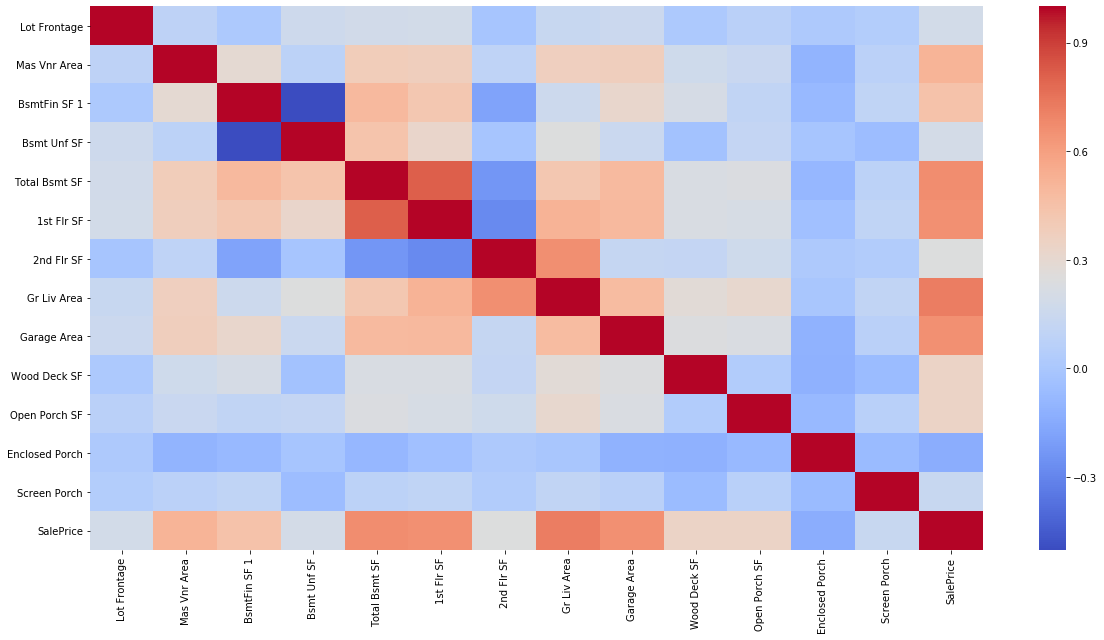

In [64]:
plt.figure(figsize=(20,10))
sns.heatmap(df[filtered_continuous_cols].corr(), cmap='coolwarm')

Reduce cols by filtering low corr cols with sales price

In [65]:
continuous_corr_cols = list(continuous_corr.index)
continuous_corr_cols.remove('SalePrice') # Remove price to prepare for poly fit

In [66]:
cols_to_poly = continuous_corr_cols[:7] # Select top features that are highly correlated to sales price
cols_to_poly

['Gr Liv Area',
 'Total Bsmt SF',
 'Garage Area',
 '1st Flr SF',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Open Porch SF']

### Adding polynomial features

In [67]:
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(df[cols_to_poly])

In [68]:
X_poly.shape

(2041, 35)

In [69]:
filtered_continuous_cols = poly.get_feature_names(cols_to_poly)

In [70]:
df_poly = pd.DataFrame(X_poly, columns=filtered_continuous_cols)

In [71]:
df.shape

(2041, 183)

In [72]:
df_poly.shape

(2041, 35)

In [73]:
remain_cols = [col for col in poly.get_feature_names(cols_to_poly) if col not in cols_to_poly]

In [74]:
df = df.reset_index()

In [75]:
df = pd.concat([df, df_poly[remain_cols]], axis=1, sort=False)

In [76]:
df[filtered_continuous_cols].shape

(2041, 35)

In [77]:
features = filtered_continuous_cols + filtered_nominal_dummies_cols + filtered_ordinal_cols + filtered_discrete_cols

In [78]:
len(features)

164

### Train test split

In [79]:
X = df[features]
y = df['SalePrice']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

### Standard Scaling

In [81]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

### Cross Validation

In [82]:
lr = LinearRegression()
lasso = LassoCV(n_alphas=10000,cv=5)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

In [83]:
lr.fit(X_train_scaled, y_train)
lr_pred=lr.predict(X_test_scaled)

In [84]:
lasso.fit(X_train_scaled, y_train)
lasso_pred=lasso.predict(X_test_scaled)

In [85]:
ridge.fit(X_train_scaled, y_train)
ridge_pred=ridge.predict(X_test_scaled)

In [86]:
lasso_coefs = pd.DataFrame({'variable': X[features].columns,
                            'coef': lasso.coef_,
                            'abs_coef': np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.head(30)

,variable,coef,abs_coef
8,Gr Liv Area Total Bsmt SF,13203.101473,13203.101473
7,Gr Liv Area^2,12866.575935,12866.575935
138,Overall Qual,11982.731448,11982.731448
9,Gr Liv Area Garage Area,8985.172512,8985.172512
18,Total Bsmt SF BsmtFin SF 1,8734.311691,8734.311691
1,Total Bsmt SF,-6676.548438,6676.548438
83,Bldg Type_1Fam,6625.739631,6625.739631
15,Total Bsmt SF Garage Area,6524.715362,6524.715362
71,Neighborhood_StoneBr,6377.002398,6377.002398
65,Neighborhood_NridgHt,5765.496508,5765.496508


In [87]:
zero_coef_vars = list(lasso_coefs[lasso_coefs['abs_coef'] == 0]['variable'])

### Model scoring

In [88]:
lr = LinearRegression()
linreg_scores = cross_val_score(lr, X_train, y_train, cv=10)


In [89]:
linreg_scores.mean()

0.9107022117568541

In [90]:
lr_rmse = print('lr_rmse:', np.sqrt(mean_squared_error(y_test,lr_pred)))
lasso_rmse = print('lasso_rmse:', np.sqrt(mean_squared_error(y_test,lasso_pred)))
ridge_rmse = print('ridge_rmse:', np.sqrt(mean_squared_error(y_test,ridge_pred)))
print('')

n = X_train_scaled.shape[0]
p = X_train_scaled.shape[1]

print('lr_adj_r2 score:', 1-(1-r2_score(y_test,lr_pred))*(n-1)/(n-p-1))
print('lasso_adj_r2 score:', 1-(1-r2_score(y_test,lasso_pred))*(n-1)/(n-p-1))
print('ridge_adj_r2 score:', 1-(1-r2_score(y_test,ridge_pred))*(n-1)/(n-p-1))

lr_rmse: 23891.142701776815
lasso_rmse: 22097.805793542546
ridge_rmse: 23324.57635448145

lr_adj_r2 score: 0.9057774284266177
lasso_adj_r2 score: 0.9193917647460038
ridge_adj_r2 score: 0.9101933209149107


Lasso performs the best

### Cleaning test data

In [91]:
df_test = pd.read_csv('../data/test.csv')
df_test_ID = df_test['Id']
df_test.drop(['Id', 'PID'], axis = 1, inplace = True)

In [92]:
missing_cols = get_missing_cols(df_test)
missing_cols

,missing_count,missing_percentage
Pool QC,875,99.544937
Misc Feature,838,95.335609
Alley,821,93.401593
Fence,707,80.432309
Fireplace Qu,422,48.009101
Lot Frontage,160,18.202503
Garage Cond,45,5.119454
Garage Qual,45,5.119454
Garage Yr Blt,45,5.119454
Garage Finish,45,5.119454


In [93]:
handle_missing_data(df_test, missing_cols);

In [94]:
# Label Encode
for col in ordinal_cat_ranking:
    df_test[col] = df_test[col].map(lambda x: ordinal_cat_ranking[col].index(x) + 1)

In [95]:
df_test[filtered_discrete_cols] = df_test[filtered_discrete_cols].astype(int) # Convert all discrete values to integer

In [96]:
df_test = df_test.join(pd.get_dummies(df_test[filtered_nominal_cols].astype(str)))

In [97]:
# polynominal
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(df_test[cols_to_poly])
df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(cols_to_poly))
df_test = df_test.reset_index()
df_test = pd.concat([df_test, df_poly[remain_cols]], axis=1, sort=False)

Tried removing features with zero lasso coef but does not improve model.

In [98]:
# features = [var for var in features if var not in zero_coef_vars]

In [99]:
features = list(lasso_coefs['variable'].values)

In [100]:
len(features)

164

In [101]:
train, test = df[features].align(df_test, join='inner', axis=1)

In [102]:
features = list(train.columns)

In [103]:
len(features)

158

In [104]:
train.shape

(2041, 158)

### Fitting-test-data

In [105]:
ss = StandardScaler()
train_scaled = ss.fit_transform(train)
test_scaled = ss.transform(test)

In [106]:
lr = LinearRegression()
lr.fit(train, y)
lr_pred=lr.predict(test)

In [107]:
lasso = LassoCV(n_alphas=10000)
lasso.fit(train_scaled,y)
lasso_pred=lasso.predict(test_scaled)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [108]:
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))
ridge.fit(train_scaled,y)
ridge_pred=ridge.predict(test_scaled)

### Top coefficient

Top 20 most important coefficient for Ridge

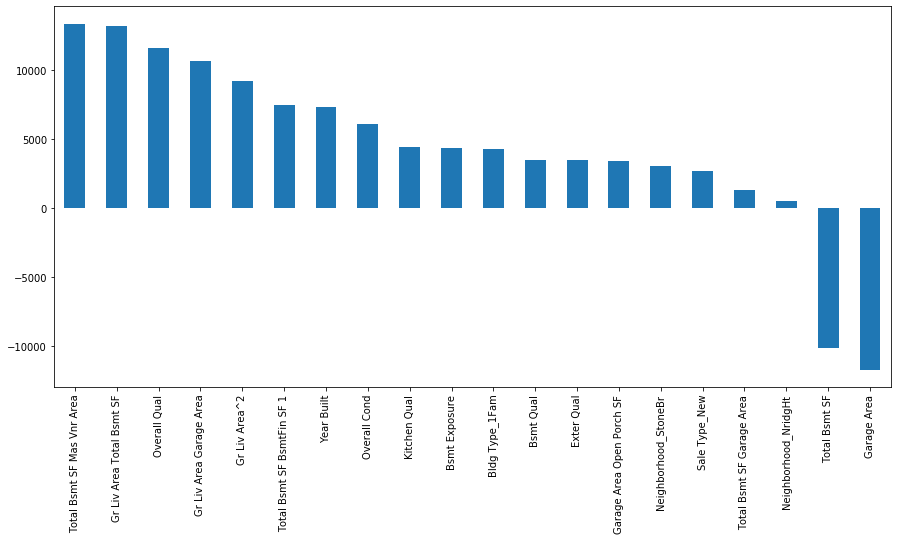

In [109]:
pd.Series(ridge.coef_[:20], index=features[:20]).sort_values(ascending=False).plot.bar(figsize=(15, 7))

Top 20 most important coefficient for Lasso: 

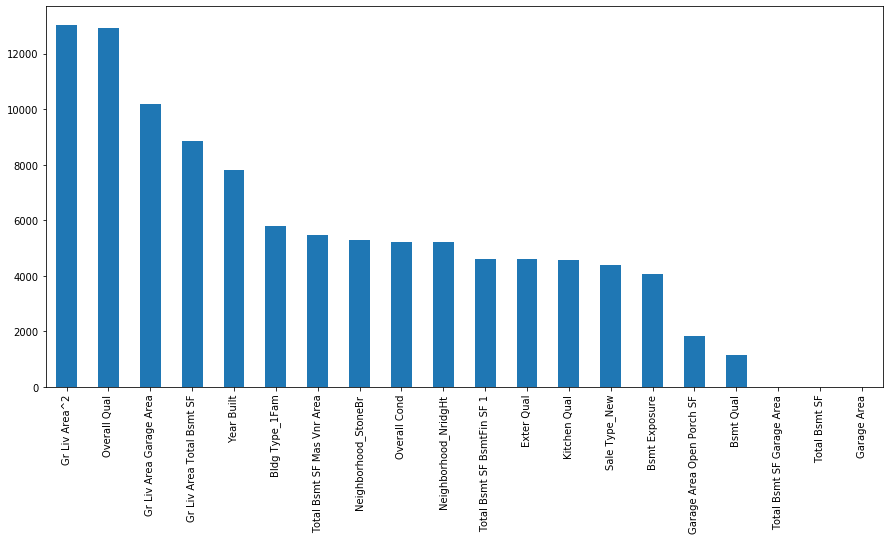

In [110]:
pd.Series(lasso.coef_[:20], index=features[:20]).sort_values(ascending=False).plot.bar(figsize=(15, 7))

### Output-results-to-csv

In [111]:
def convert_pred_to_csv(pred, model_type='lr'):
    final = pd.DataFrame([df_test_ID, pred]).T
    final['Id'] = final['Id'].astype(int)    
    final.rename(columns={'Unnamed 0': 'SalePrice'}, inplace= True)  
    final.to_csv('../data/{}_submission.csv'.format(model_type), index=False)    
    return final

In [112]:
convert_pred_to_csv(lr_pred)
convert_pred_to_csv(lasso_pred,'lasso')
convert_pred_to_csv(ridge_pred,'ridge')

,Id,SalePrice
0,2658,135551.147086
1,2718,163553.120220
2,2414,218446.346901
3,1989,100281.476885
4,625,175861.255289
...,...,...
874,1662,192136.946147
875,1234,213974.487428
876,1373,121627.482549
877,1672,110098.363799


In [113]:
convert_pred_to_csv(lasso_pred).describe()

,Id,SalePrice
count,879.000000,879.000000
mean,1445.588168,180865.817218
std,850.717105,78544.312076
min,2.000000,36917.246320
25%,692.500000,128029.716872
50%,1435.000000,159631.574116
75%,2197.000000,217841.472009
max,2928.000000,802094.659002
